# **DSR DengAI Project Competition**
# Team: Justin, Adam, Eugene, Paul 

| **Pipeline Steps**                                              | **Script files**                          |
|-----------------------------------------------------------|-------------------------------------------|
| 1) Read and pre-process data                              | pre_processing.py                         |
| 2) Feature engineering                                    | feature_engineering.py                    |
| 3) Train models                                           | model_training.py, <br>tree_model_training.py |
| 4) Predict on test_features <br>and write submission file | final_predict.py                          |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import scripts.pre_processing as pp
import scripts.feature_engineering as fe
import scripts.tree_model_training as tm
import scripts.linear_model_training as lm
from scripts.model_evaluation import regression_evaluation
import scripts.final_predict as fp
import scripts.data_viz as dv

## 1) Pre-process data

In [2]:
# Read in data files 
train_features = pd.read_csv('./data/dengue_features_train.csv')
train_target = pd.read_csv('./data/dengue_labels_train.csv')
test_features = pd.read_csv('./data/dengue_features_test.csv')

In [3]:
# Merge features and target data
data = pp.merge_data(train_features, train_target, test_features, inc_test=False)

# Run processing and split by city
train_iq = pp.pre_process(data, 'iq', remove_anomalies=True, inc_test=False)
train_sj = pp.pre_process(data, 'sj', remove_anomalies=True, inc_test=False)

# Run checks for missing values
assert train_iq.isnull().any().any() == False
assert train_sj.isnull().any().any() == False
Xy_iq = train_iq.copy()
Xy_sj = train_sj.copy()
print(f'train_iq shape: {Xy_iq.shape}') 
print(f'train_sj shape: {Xy_sj.shape}') 

train_iq shape: (463, 24)
train_sj shape: (928, 24)


## 2) Feature engineering

In [4]:
# Run feature engineering 
Xy_iq = fe.cyclical_encode_date(Xy_iq)
Xy_sj = fe.cyclical_encode_date(Xy_sj)
#Xy_iq = fe.shift_features(Xy_iq, periods=1)
#Xy_sj = fe.shift_features(Xy_sj, periods=1)
Xy_iq = fe.drop_date(Xy_iq)
Xy_sj = fe.drop_date(Xy_sj)
Xy_iq = fe.add_rolling(Xy_iq, 'iq', fillna=True)
Xy_sj = fe.add_rolling(Xy_sj, 'sj', fillna=True)

print(f'train_iq shape: {Xy_iq.shape}') 
print(f'train_sj shape: {Xy_sj.shape}') 

train_iq shape: (463, 44)
train_sj shape: (928, 44)


### Charting different features 

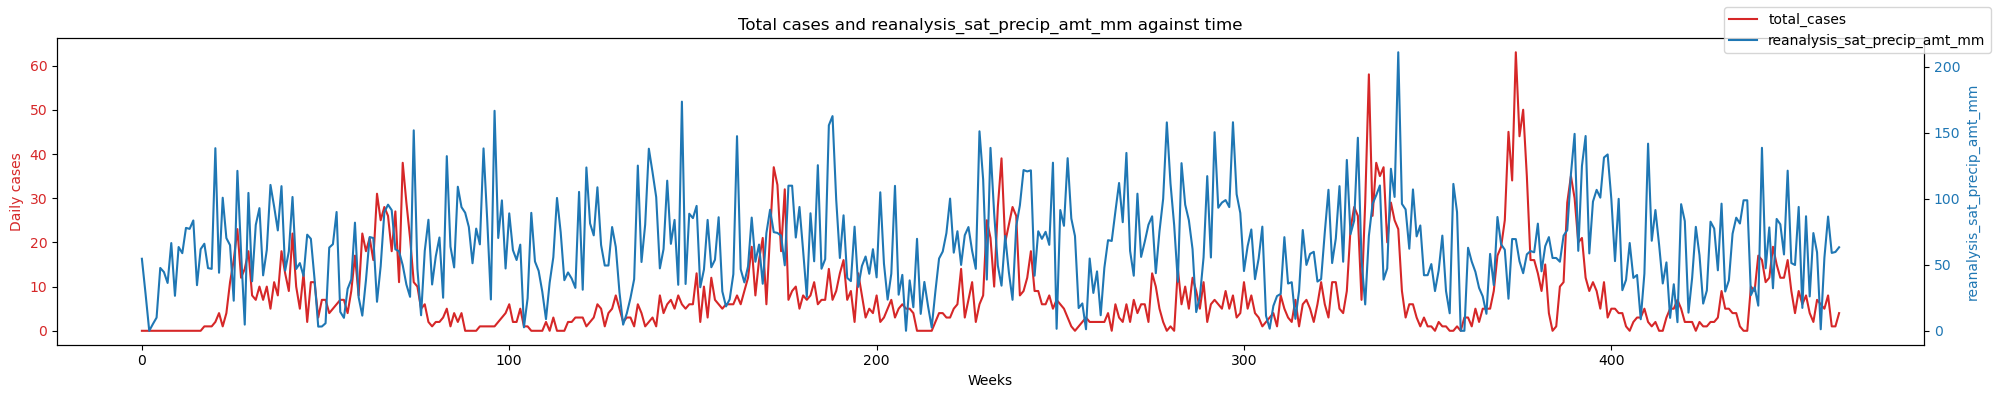

In [5]:
data = Xy_iq
y = Xy_iq['total_cases']
feature = 'reanalysis_sat_precip_amt_mm'
dv.feature_output_chart(data, y, feature, city='iq')


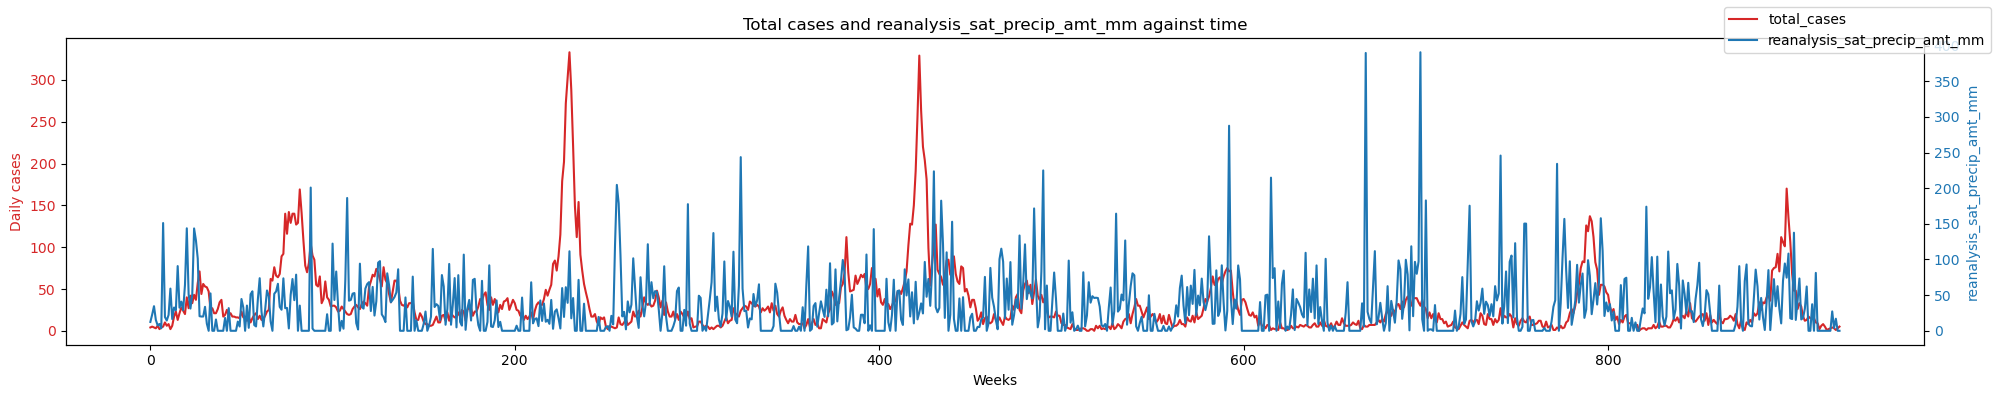

In [6]:
data = Xy_sj
y = Xy_sj['total_cases']
feature = 'reanalysis_sat_precip_amt_mm'
dv.feature_output_chart(data, y, feature, city='sj')

### Utilising rolling averages 

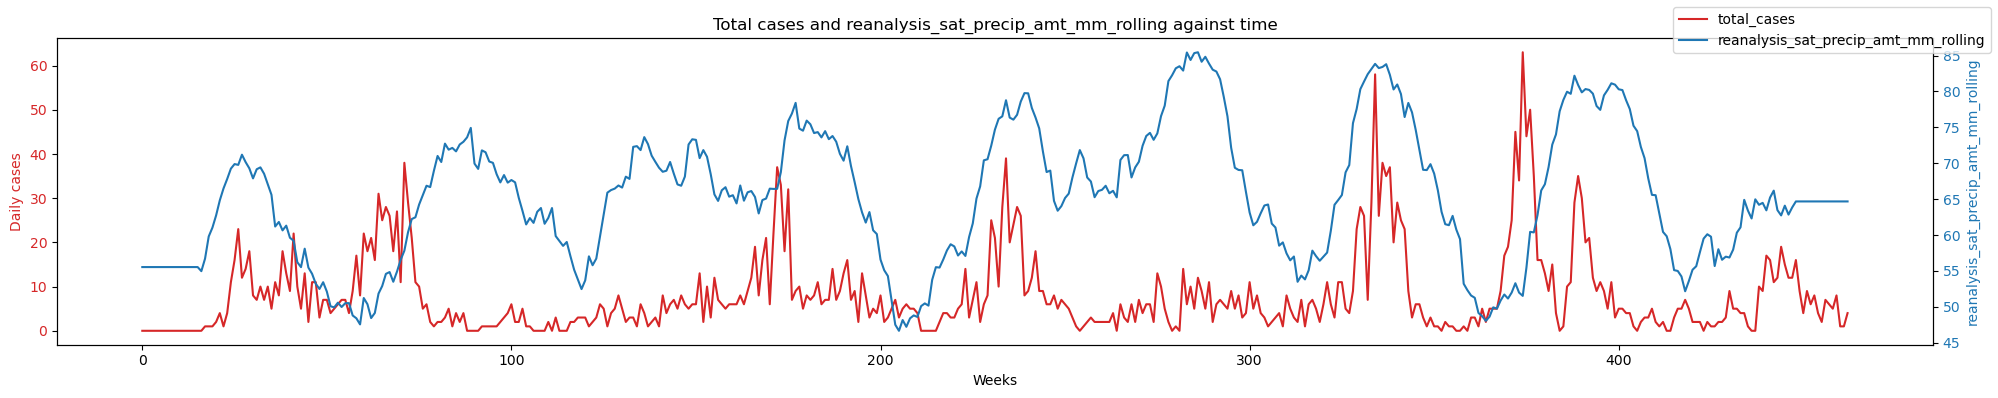

In [7]:
data = Xy_iq
y = Xy_iq['total_cases']
feature = 'reanalysis_sat_precip_amt_mm_rolling'
dv.feature_output_chart(data, y, feature, city='iq')


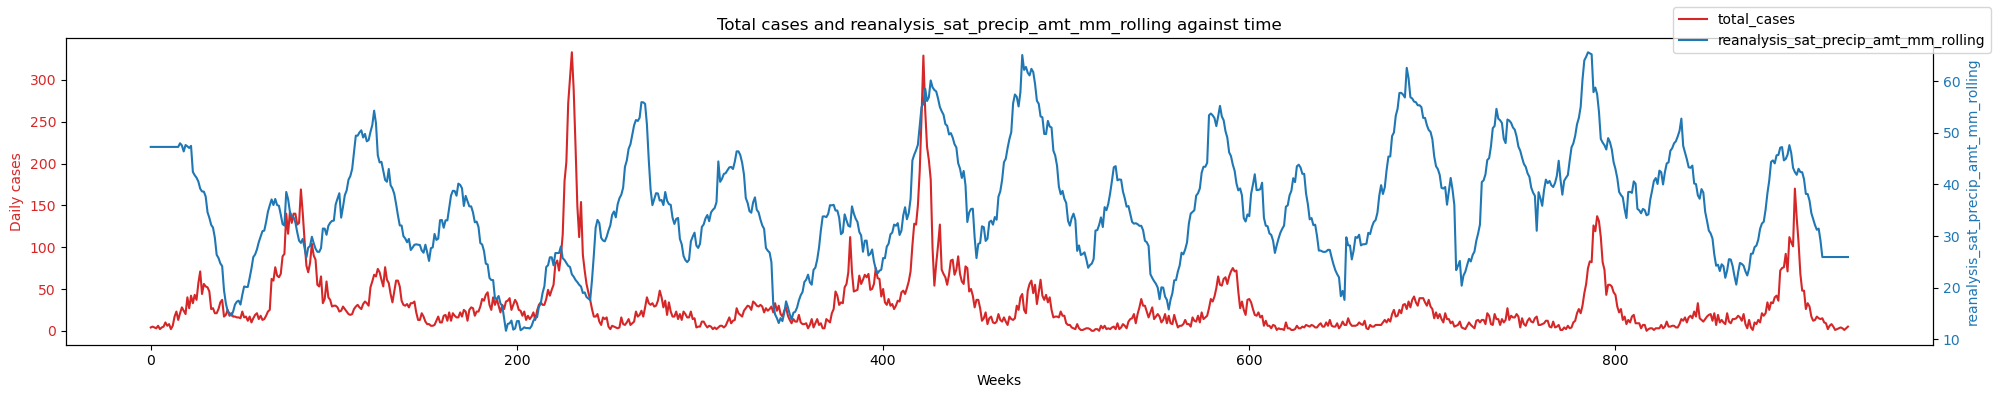

In [8]:
data = Xy_sj
y = Xy_sj['total_cases']
feature = 'reanalysis_sat_precip_amt_mm_rolling'
dv.feature_output_chart(data, y, feature, city='sj')

### Select features that we want for the model

In [9]:
Xy_iq = fe.remove_original_cols(Xy_iq)
Xy_sj = fe.remove_original_cols(Xy_sj)

Text(0.5, 1.0, 'San Juan Variable Correlations')

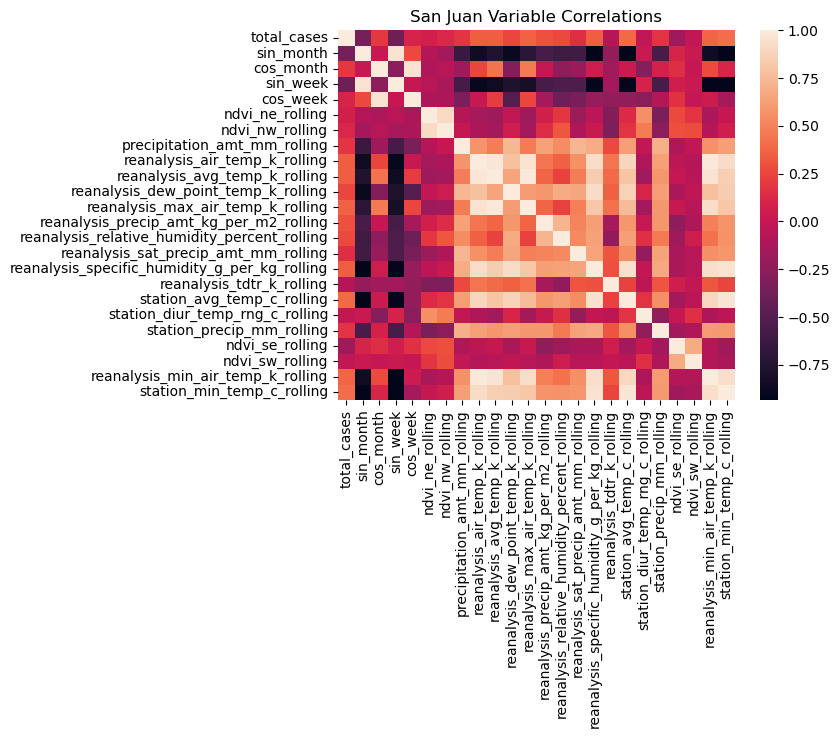

In [10]:
sj_corr_heat = sns.heatmap(Xy_sj.corr())
plt.title('San Juan Variable Correlations')

## 3) Train models

In [11]:
# Split data into X and y
X_iq = Xy_iq.drop(labels=['total_cases'], axis=1)
y_iq = Xy_iq['total_cases']
X_sj = Xy_sj.drop(labels=['total_cases'], axis=1)
y_sj = Xy_sj['total_cases']
assert len(X_iq) == len(y_iq)

### Baseline model
For Iquitos:  MAE 6.4

For San Juan: MAE 24.3

In [12]:
# Baseline model predictions for Iquitos (Iq)
bl_pred_train = np.tile(np.mean(y_iq), len(y_iq))
bl_pred_test = np.tile(np.mean(y_iq), len(y_iq))
print('For Iquitos: ')
regression_evaluation(y_iq, y_iq, bl_pred_train, bl_pred_test)

# Baseline model predictions for San Jose (sj)
bl_pred_train = np.tile(np.mean(y_sj), len(y_sj))
bl_pred_test = np.tile(np.mean(y_sj), len(y_sj))
print('For San Jose: ')
regression_evaluation(y_sj, y_sj, bl_pred_train, bl_pred_test)

For Iquitos: 

    Evaluation metrics:
        RMSE train: 9.24327523359923
        RMSE test: 9.24327523359923
        MAE train: 6.380110930218457
        MAE test: 6.380110930218457 
    
For San Jose: 

    Evaluation metrics:
        RMSE train: 39.06484683794444
        RMSE test: 39.06484683794444
        MAE train: 24.198600995838284
        MAE test: 24.198600995838284 
    


(39.06484683794444, 39.06484683794444, 24.198600995838284, 24.198600995838284)

### Poisson regression model

In [13]:
warnings.filterwarnings('ignore') 
# Poisson regression model for iq
X, y = X_iq, y_iq
lm.poisson_reg_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,alpha,mat_iter
0,1,8.367577,5.100186,5.207056,3.727387,0.6,100
1,1,8.138569,4.974862,5.092482,3.634342,0.6,200
2,1,8.287986,5.176592,5.100348,3.768775,1.0,100
3,1,8.242934,5.126108,5.074756,3.725414,1.0,200
4,2,12.679147,6.492259,8.807430,4.527521,0.6,100
5,2,12.881008,6.165668,9.119844,4.335847,0.6,200
6,2,12.902473,6.274440,9.291552,4.403810,1.0,100
7,2,12.588676,6.207327,8.823180,4.385682,1.0,200


In [14]:
# Poisson regression model for sj
X, y = X_sj, y_sj
lm.poisson_reg_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,alpha,mat_iter
0,1,59.222771,27.340323,36.211144,17.564043,0.6,100
1,1,85.669616,20.548946,57.325290,13.474971,0.6,200
2,1,76.749876,21.094814,51.566974,13.872018,1.0,100
3,1,68.415993,21.497949,46.614228,14.091954,1.0,200
4,2,28.524844,36.787803,21.777056,21.598668,0.6,100
5,2,33.076070,35.409443,25.406132,21.137445,0.6,200
6,2,33.562132,37.463013,25.719932,21.790601,1.0,100
7,2,32.789898,35.594663,25.097386,21.146557,1.0,200


<Axes: >

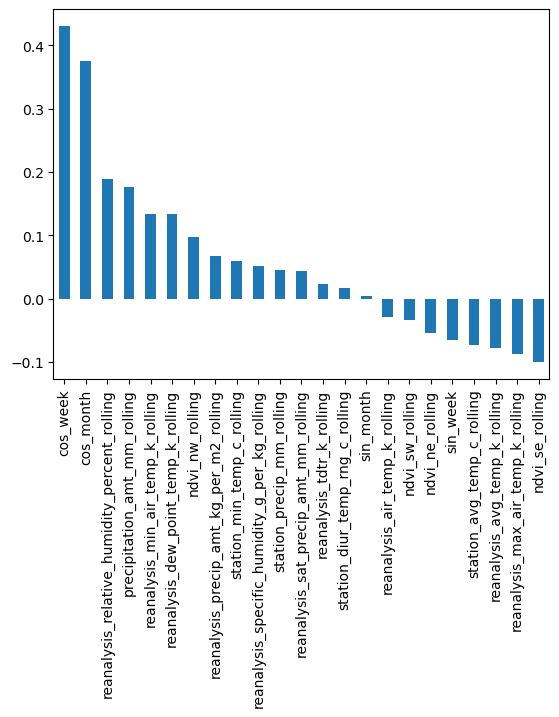

In [15]:
# Poisson get parameters for iq 
X, y = X_iq, y_iq
coefs = lm.poisson_get_coefs(X, y)
coefs.sort_values(ascending=False).plot.bar()

<Axes: >

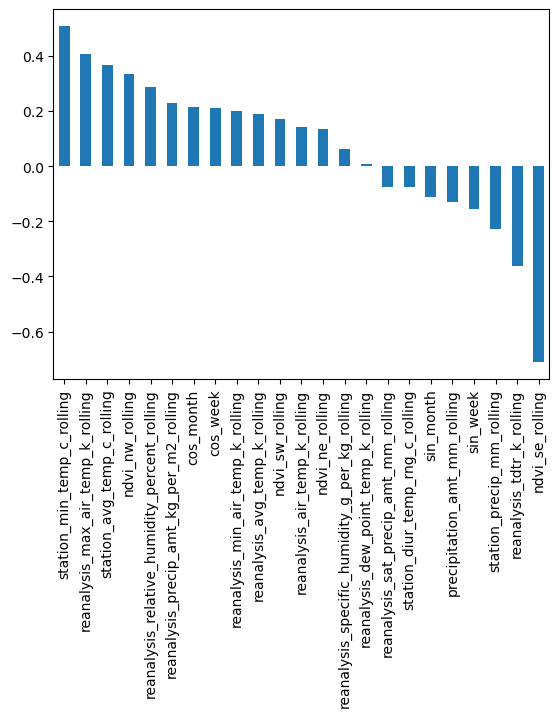

In [16]:
# Poisson get parameters for sj 
X, y = X_sj, y_sj
coefs = lm.poisson_get_coefs(X, y)
coefs.sort_values(ascending=False).plot.bar()

### Random forest model

In [17]:
# Random forest model for iq
X, y = X_iq, y_iq
tm.rforest_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,n_estimators,max_depth,min_samples_split,min_samples_leaf
0,1,8.073353,3.457473,5.318542,2.520827,100,4,2,2
1,1,7.904993,3.462396,5.228623,2.512213,100,4,5,2
2,1,8.003511,2.478588,5.318993,1.618218,100,8,2,2
3,1,8.168711,2.701187,5.484784,1.762690,100,8,5,2
4,1,8.080880,3.486087,5.317261,2.534004,200,4,2,2
5,1,8.144128,3.546008,5.369380,2.579769,200,4,5,2
6,1,8.221216,2.422833,5.537129,1.598958,200,8,2,2
7,1,8.206630,2.626994,5.438917,1.724925,200,8,5,2
8,2,11.400429,4.916555,7.119614,3.461133,100,4,2,2
9,2,11.347924,4.965088,7.086963,3.503015,100,4,5,2


<Axes: >

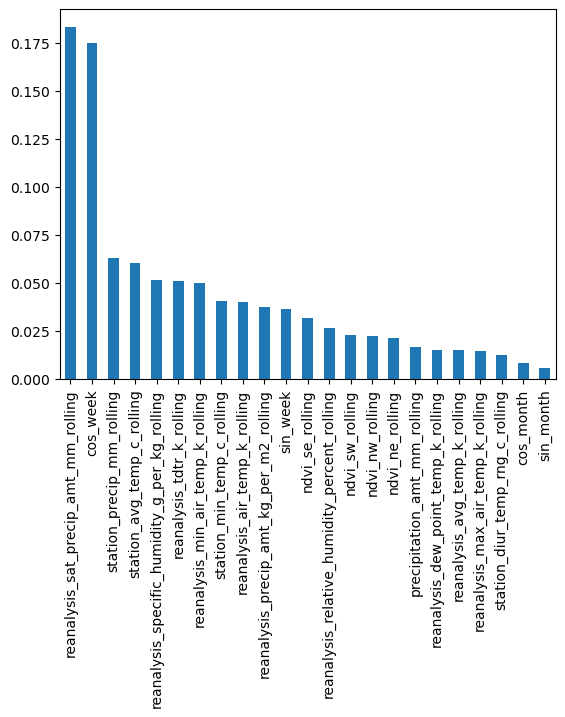

In [18]:
# Random forest feature importance for iq
X, y = X_iq, y_iq
feature_importances = tm.rf_feature_importance(X, y)
feature_importances.sort_values(ascending=False).plot.bar()

<Axes: >

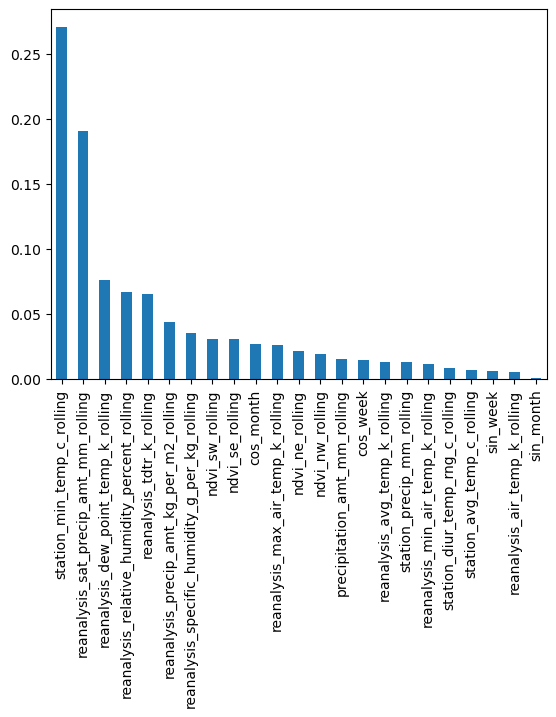

In [19]:
# Random forest feature importance for sj
X, y = X_sj, y_sj
feature_importances = tm.rf_feature_importance(X, y)
feature_importances.sort_values(ascending=False).plot.bar()

### XGBoost model

In [48]:
# XG boost model for iq
X, y = X_iq, y_iq
score_iq, plots_iq = tm.xg_model(X, y)
score_iq.sort_values(by='mae_test', ascending=True)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,learning_rate,n_estimators,max_depth,subsample,colsample_bytree,reg_lambda,gamma
3,1,8.372188,2.182560,5.363204,1.303514,0.05,100,5,0.6,0.8,5,10
0,1,8.336221,2.271631,5.396639,1.388237,0.05,100,4,0.6,0.8,5,10
6,1,8.459621,2.129567,5.423827,1.259274,0.05,100,6,0.6,0.8,5,10
7,1,8.620704,2.669431,5.572025,1.533022,0.05,100,6,0.6,0.8,10,10
4,1,8.595351,2.696419,5.576470,1.555056,0.05,100,5,0.6,0.8,10,10
1,1,8.600796,2.758703,5.581824,1.609351,0.05,100,4,0.6,0.8,10,10
2,1,8.462890,3.392137,5.611901,1.943784,0.05,100,4,0.6,0.8,20,10
8,1,8.498550,3.294164,5.657365,1.852084,0.05,100,6,0.6,0.8,20,10
5,1,8.521697,3.305220,5.673613,1.864876,0.05,100,5,0.6,0.8,20,10
12,2,11.704720,2.314763,7.283890,1.495580,0.05,100,5,0.6,0.8,5,10


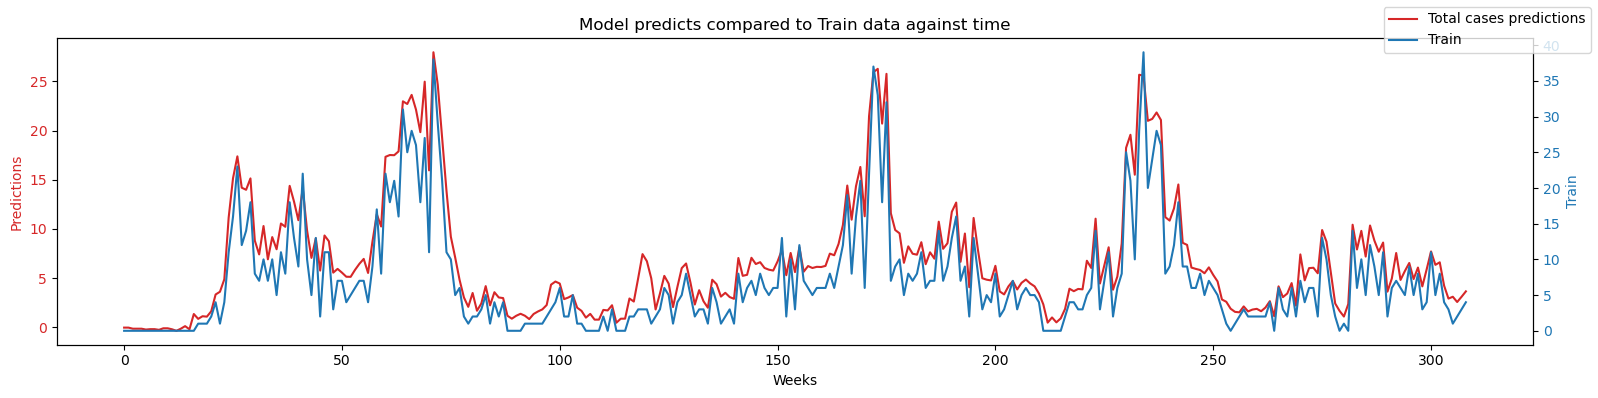

In [49]:
row = 12
y_pred = plots_iq[row]['pred_train']
y = plots_iq[row]['y_train']
test_or_train = 'Train'
dv.plot_train_test(y_pred, y, test_or_train=test_or_train)


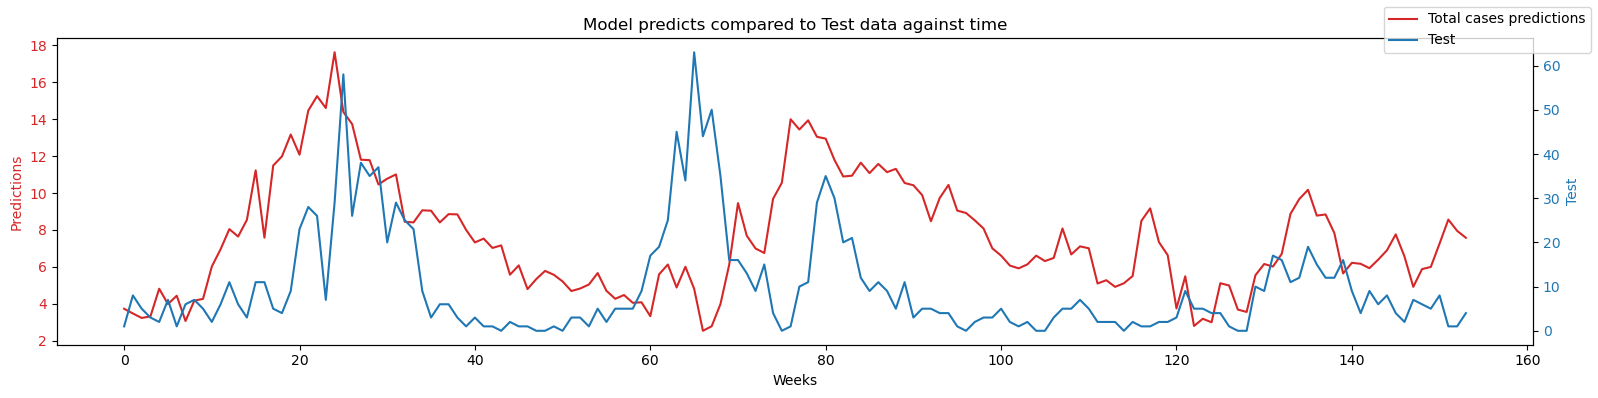

In [50]:
row = 12
y_pred = plots_iq[row]['pred_test']
y = plots_iq[row]['y_test']
test_or_train = 'Test'
dv.plot_train_test(y_pred, y, test_or_train=test_or_train)


In [51]:
# XG boost model for sj
X, y = X_sj, y_sj
tm.xg_model(X, y)
score_sj, plots_sj = tm.xg_model(X, y)
score_sj.sort_values(by='mae_test', ascending=True)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,learning_rate,n_estimators,max_depth,subsample,colsample_bytree,reg_lambda,gamma
17,2,25.438655,15.783358,17.234038,6.470176,0.05,100,6,0.6,0.8,20,10
14,2,24.862226,16.835507,17.995437,7.355617,0.05,100,5,0.6,0.8,20,10
16,2,25.974399,12.020933,19.484332,5.084824,0.05,100,6,0.6,0.8,10,10
11,2,25.682509,18.423309,19.503571,8.679924,0.05,100,4,0.6,0.8,20,10
13,2,26.014606,13.255336,20.261785,6.148522,0.05,100,5,0.6,0.8,10,10
8,1,42.816328,17.983967,22.246958,5.902185,0.05,100,6,0.6,0.8,20,10
15,2,27.608642,8.820201,22.599414,4.357889,0.05,100,6,0.6,0.8,5,10
5,1,43.213221,18.071498,22.867554,6.109166,0.05,100,5,0.6,0.8,20,10
10,2,28.006636,14.766722,22.933568,7.651574,0.05,100,4,0.6,0.8,10,10
2,1,43.212799,18.430537,23.583886,6.540255,0.05,100,4,0.6,0.8,20,10


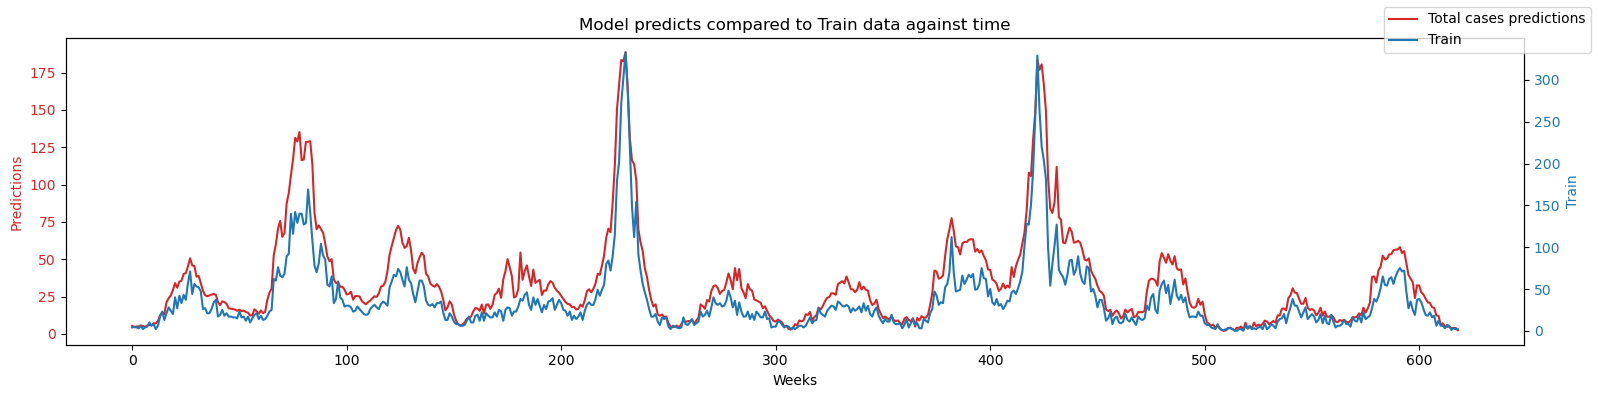

In [52]:
row = 17
y_pred = plots_sj[row]['pred_train']
y = plots_sj[row]['y_train']
test_or_train = 'Train'
dv.plot_train_test(y_pred, y, test_or_train=test_or_train)


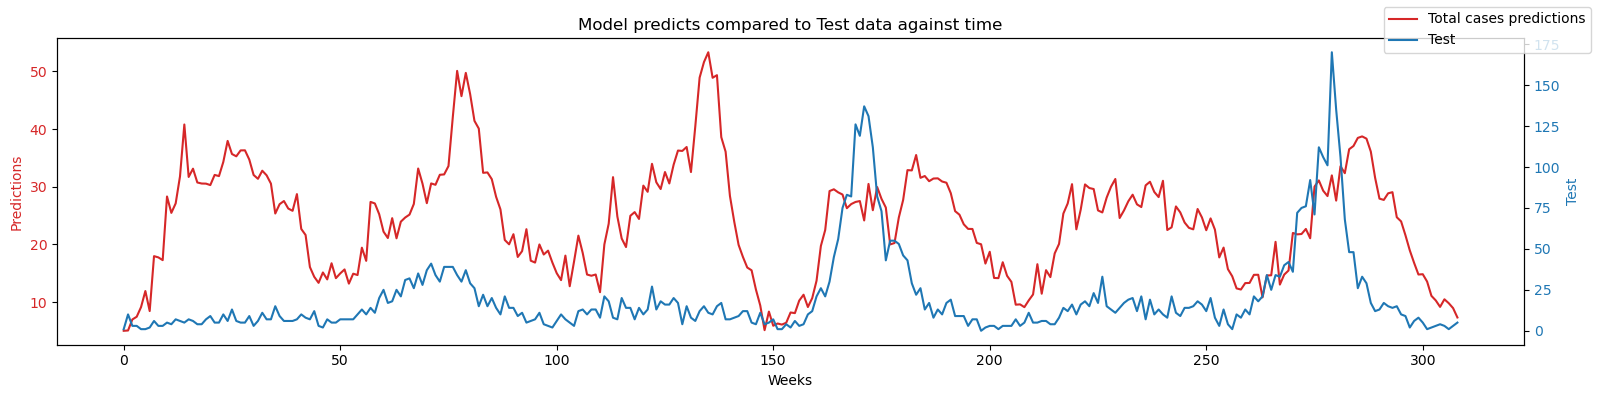

In [53]:
row = 17
y_pred = plots_sj[row]['pred_test']
y = plots_sj[row]['y_test']
test_or_train = 'Test'
dv.plot_train_test(y_pred, y, test_or_train=test_or_train)

## 4) Predict on test data with chosen model and write file

Repeat the above transforms on the test set

In [54]:
# Code to run pipeline on dataset including test_features, and then take only test_features to run the final model
# Merge features and target data
data = pp.merge_data(train_features, train_target, test_features, inc_test=True)

# Run processing and split by city
Xy_iq_comb = pp.pre_process(data, 'iq', remove_anomalies=True, inc_test=True)
Xy_sj_comb = pp.pre_process(data, 'sj', remove_anomalies=True, inc_test=True)
assert Xy_iq_comb.isnull().any().any() == False
assert Xy_sj_comb.isnull().any().any() == False

# Run feature engineering 
Xy_iq_comb = fe.cyclical_encode_date(Xy_iq_comb)
Xy_sj_comb = fe.cyclical_encode_date(Xy_sj_comb)
#Xy_iq_comb = fe.shift_features(Xy_iq_comb, periods=1)
#Xy_sj_comb = fe.shift_features(Xy_sj_comb, periods=1)
Xy_iq_comb = fe.drop_date(Xy_iq_comb)
Xy_sj_comb = fe.drop_date(Xy_sj_comb)
Xy_iq_comb = fe.add_rolling(Xy_iq_comb, 'iq', fillna=True)
Xy_sj_comb = fe.add_rolling(Xy_sj_comb, 'sj', fillna=True)
Xy_iq_comb = fe.remove_original_cols(Xy_iq_comb)
Xy_sj_comb = fe.remove_original_cols(Xy_sj_comb)
print(f'Xy_iq_comb shape: {Xy_iq_comb.shape}') 
print(f'Xy_sj_comb shape: {Xy_sj_comb.shape}') 

# Split data into X and y
X_iq_comb = Xy_iq_comb.drop(labels=['total_cases'], axis=1)
y_train_iq = Xy_iq_comb.loc[Xy_iq_comb['total_cases'] >= 0, Xy_iq_comb.columns == 'total_cases']
y_test_iq = Xy_iq_comb.loc[Xy_iq_comb['total_cases'] < 0, Xy_iq_comb.columns == 'total_cases']
X_sj_comb = Xy_sj_comb.drop(labels=['total_cases'], axis=1)
y_train_sj = Xy_sj_comb.loc[Xy_sj_comb['total_cases'] >= 0, Xy_sj_comb.columns == 'total_cases']
y_test_sj = Xy_sj_comb.loc[Xy_sj_comb['total_cases'] < 0, Xy_sj_comb.columns == 'total_cases']

# Take now only the test features 
X_train_iq = X_iq_comb.iloc[:(X_iq_comb.shape[0] - y_test_iq.shape[0]) , :]
X_train_sj = X_sj_comb.iloc[:(X_sj_comb.shape[0] - y_test_sj.shape[0]) , :]
X_test_iq = X_iq_comb.iloc[(X_iq_comb.shape[0] - y_test_iq.shape[0]): , :]
X_test_sj = X_sj_comb.iloc[(X_sj_comb.shape[0] - y_test_sj.shape[0]): , :]

print(X_train_iq.shape, y_train_iq.shape)
print(X_train_sj.shape, y_train_sj.shape)
assert (X_train_iq.shape[0] == y_train_iq.shape[0])
assert (X_train_sj.shape[0] == y_train_sj.shape[0])


Xy_iq_comb shape: (619, 24)
Xy_sj_comb shape: (1188, 24)
(463, 23) (463, 1)
(928, 23) (928, 1)


In [55]:
# Select data and chosen model and hyperparameters for final prediction

params = dict(learning_rate=0.05,
        n_estimators=100,
        max_depth=5,
        subsample=0.6,
        colsample_bytree=0.8,
        reg_lambda=10,
        gamma=10)
 
# Iquitos, iq
X_test_iq = X_test_iq
X_train_iq = X_train_iq
y_train_iq = y_train_iq
model_iq = 'XGBRegressor'
params_iq = params

# San Jose, sj
X_test_sj = X_test_sj
X_train_sj = X_train_sj
y_train_sj = y_train_sj
model_sj = 'XGBRegressor'
params_sj = params


In [56]:
# Do final prediction and create final DataFrame for submission 
iq_preds = fp.final_predict(X_test_iq, X_train_iq, y_train_iq, city='iq', model=model_iq, params=params_iq)
sj_preds = fp.final_predict(X_test_sj, X_train_sj, y_train_sj, city='sj', model=model_sj, params=params_sj)
final_iq = test_features.loc[test_features.city == 'iq', ['city','year','weekofyear']]
final_sj = test_features.loc[test_features.city == 'sj', ['city','year','weekofyear']]

assert len(iq_preds) == final_iq.shape[0]
assert len(sj_preds) == final_sj.shape[0]

final_iq['total_cases'] = iq_preds.tolist()
final_sj['total_cases'] = sj_preds.tolist()
final = pd.concat([final_sj, final_iq], axis=0)
final['total_cases'] = final['total_cases'].astype(int)

assert final.isnull().any().any() == False
assert final.shape[0] == 416


### Compare predictions fron training data to actual cases

In [57]:
preds_train_iq, y_train_iq = fp.preds_for_plot(X_test_iq, X_train_iq, y_train_iq, model=model_iq, params=params_iq)
preds_train_sj, y_train_sj = fp.preds_for_plot(X_test_sj, X_train_sj, y_train_sj, model=model_sj, params=params_sj)

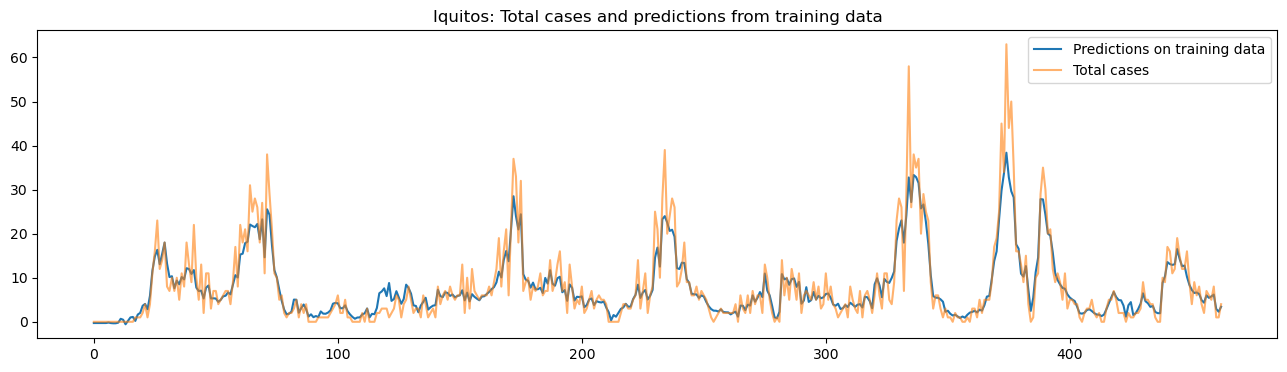

In [59]:
plt.figure(figsize=(16,4))
x = np.arange(preds_train_iq.shape[0])
plt.plot(x, preds_train_iq, label='Predictions on training data')
plt.plot(x, y_train_iq, label='Total cases', alpha=0.6)
plt.title('Iquitos: Total cases and predictions from training data')
plt.legend();

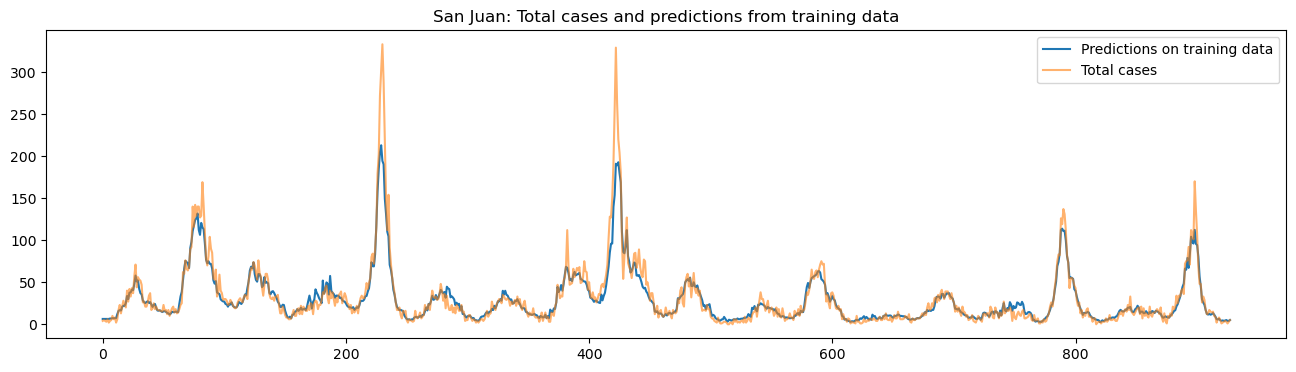

In [61]:
plt.figure(figsize=(16,4))
x = np.arange(preds_train_sj.shape[0])
plt.plot(x, preds_train_sj, label='Predictions on training data')
plt.plot(x, y_train_sj, label='Total cases', alpha=0.6)
plt.title('San Juan: Total cases and predictions from training data')
plt.legend();

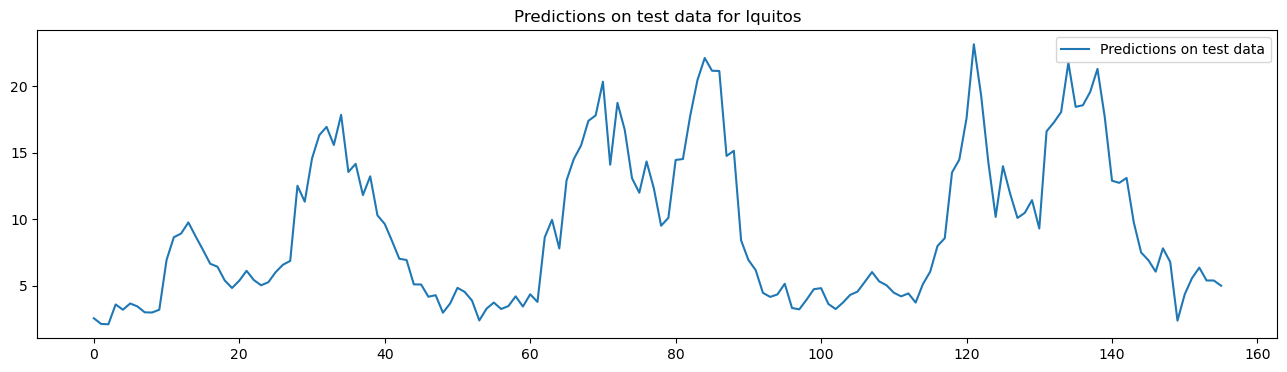

In [63]:
# Plot predictions on test data 
plt.figure(figsize=(16,4))
plt.plot(iq_preds, label='Predictions on test data')
plt.title('Predictions on test data for Iquitos')
plt.legend()

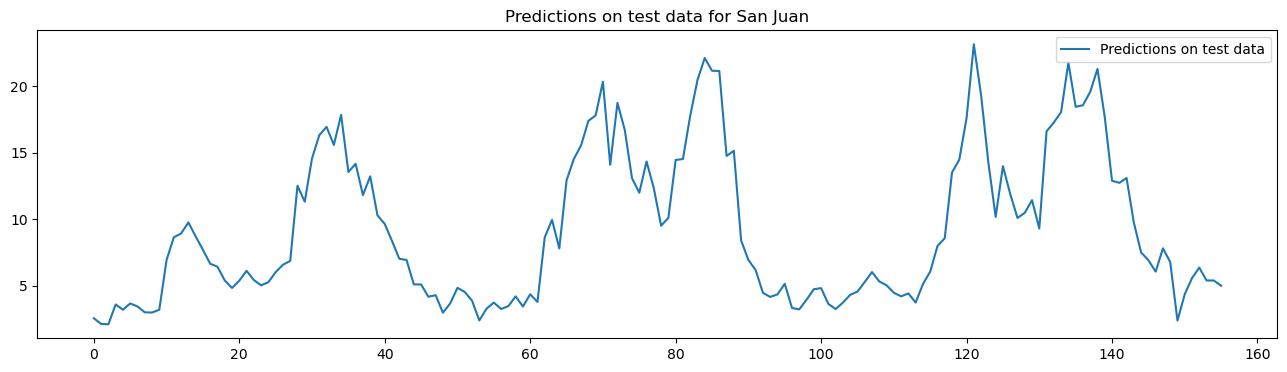

In [64]:
# Plot predictions on test data 
plt.figure(figsize=(16,4))
plt.plot(iq_preds, label='Predictions on test data')
plt.title('Predictions on test data for San Juan')
plt.legend()

### Write final predictions to csv final for submission

In [ ]:
# Write to file for submission 
print('Writing submission file to folder: ')
final.to_csv('for_submission_XGB_no_shift.csv', index=False)

## FINAL SUBMISSION SCORE for MAE:  **24.2**